In [77]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(7)
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
sns.set(style="darkgrid")
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb  # GBM algorithm
from xgboost import XGBRegressor


## 数据读取

In [78]:
conn = sqlite3.connect('all_house_infos.db')
sql = "select * from HouseInfo "

all_df = pd.read_sql(sql=sql, con=conn)

In [79]:
all_df.shape

(6436, 25)

In [32]:
all_df.head(3)

所属小区     房屋单价   建筑面积  参考首付   建造年代 房屋朝向 参考月供  房屋类型 所在楼层 装修程度 产权年限 配套电梯  \
0      三箭瑞福苑  28448.0  116.0  99.0  2012年    东   暂无  普通住宅   低层   毛坯  70年    有   
1      新泉城名苑  29474.0   95.0  84.0  2015年    南   暂无  普通住宅   中层  精装修  70年    有   
2  绿地IFC中央公馆  23571.0  112.0  79.2  2018年   南北   暂无  普通住宅   高层  精装修  70年    有   

  房本年限   产权性质 唯一住房 一手房源          经度         纬度  房屋户型_室数  房屋户型_厅数  房屋户型_卫数  \
0  满二年  保障性住房    否    否  117.004958  36.657665        3        1        1   
1  满五年  商品房住宅    是    否  116.989272  36.659001        2        2        1   
2   暂无  商品房住宅    是    是  117.111705  36.682556        3        2        1   

   总楼层                                                 图片  \
0   28  https://pages.anjukestatic.com/usersite/site/i...   
1   18  https://pages.anjukestatic.com/usersite/site/i...   
2   25  https://pages.anjukestatic.com/usersite/site/i...   

                                                  链接         总价  
0  https://jinan.anjuke.com/prop/view/A1965502333...  3299968.0  
1  https://jinan.anjuke.com/prop/view/A1974008440...  2800030.0  
2  https://jinan.anjuke.com/prop/view/A1922894672...  2639952.0

## 特征工程

In [33]:
del all_df['参考首付']
del all_df['参考月供']

In [34]:
# 所属小区平均单价
tmp = all_df[['所属小区', '房屋单价']].groupby('所属小区').mean()
tmp = tmp.reset_index()
tmp.columns = ['所属小区', '所属小区平均单价']
tmp.head(3)

所属小区   所属小区平均单价
0  MUM河畔景苑   6474.125
1     丁苑小区  14286.000
2   丁豪蓝调国际  10059.500

In [35]:
all_df = pd.merge(all_df, tmp, on='所属小区', how='left')

In [36]:
# 所属小区房源数
tmp1 = all_df[['所属小区', '房屋单价']].groupby('所属小区').count()
tmp1 = tmp1.reset_index()
tmp1.columns = ['所属小区', '所属小区房源个数']
tmp1.head(3)

所属小区  所属小区房源个数
0  MUM河畔景苑         8
1     丁苑小区         1
2   丁豪蓝调国际         8

In [37]:
tmp = pd.merge(tmp, tmp1, on='所属小区', how='left')

In [38]:
tmp.head(3)

所属小区   所属小区平均单价  所属小区房源个数
0  MUM河畔景苑   6474.125         8
1     丁苑小区  14286.000         1
2   丁豪蓝调国际  10059.500         8

In [39]:
# 所属小区中心经纬度
tmp2 = all_df[['所属小区', '经度']].groupby('所属小区').mean()
tmp2 = tmp2.reset_index()
tmp2.columns = ['所属小区', '中心经度']

tmp = pd.merge(tmp, tmp2, on='所属小区', how='left')

tmp2 = all_df[['所属小区', '纬度']].groupby('所属小区').mean()
tmp2 = tmp2.reset_index()
tmp2.columns = ['所属小区', '中心纬度']

tmp = pd.merge(tmp, tmp2, on='所属小区', how='left')

tmp.head(3)

所属小区   所属小区平均单价  所属小区房源个数        中心经度       中心纬度
0  MUM河畔景苑   6474.125         8  117.017561  36.723606
1     丁苑小区  14286.000         1  116.982612  36.649212
2   丁豪蓝调国际  10059.500         8  117.102355  36.690472

In [40]:
tmp.to_csv('小区均价房源数和经纬度.csv', index=False, encoding='utf8')

In [41]:
all_df = pd.merge(all_df, tmp, on='所属小区', how='left')

In [42]:
# 建造年代平均单价
tmp = all_df[['建造年代', '房屋单价']].groupby('建造年代').mean()
tmp = tmp.reset_index()
tmp.columns = ['建造年代', '建造年代平均单价']
tmp.head(3)

建造年代      建造年代平均单价
0  1980年  21126.571429
1  1982年  13417.000000
2  1985年  20660.250000

In [43]:
tmp_map = {}
for i, row in tmp.iterrows():
    tmp_map[row['建造年代']] = row['建造年代平均单价']
print(tmp_map)

{'1980年': 21126.571428571428, '1982年': 13417.0, '1985年': 20660.25, '1986年': 18267.0, '1987年': 25267.0, '1988年': 19653.615384615383, '1989年': 17615.75, '1990年': 18921.794520547945, '1991年': 18024.454545454544, '1992年': 20140.022222222222, '1993年': 19312.75, '1994年': 19048.129032258064, '1995年': 18604.570135746606, '1996年': 17822.60824742268, '1997年': 19061.946666666667, '1998年': 18071.160975609757, '1999年': 18075.729411764707, '2000年': 17851.63255033557, '2001年': 19989.174418604653, '2002年': 15449.122807017544, '2003年': 16345.119047619048, '2004年': 16936.28695652174, '2005年': 16370.767857142857, '2006年': 16952.60736196319, '2007年': 15292.27027027027, '2008年': 13548.521126760563, '2009年': 17056.46923076923, '2010年': 16562.82515991471, '2011年': 19416.546875, '2012年': 17531.78605769231, '2013年': 15631.142222222223, '2014年': 16428.931428571428, '2015年': 16552.810650887575, '2016年': 17146.583877995643, '2017年': 16975.844311377245, '2018年': 14942.460714285715, '2019年': 14037.004132231405, '20

In [44]:
all_df = pd.merge(all_df, tmp, on='建造年代', how='left')

In [45]:
all_df['建造年代'] = all_df['建造年代'].map(lambda x: int(x[:-1]) if x != '暂无' else 2015)

In [46]:
chaoxiang_map = {'东':0, '东北':1, '东南':2, '东西':3, '北':4, '南':5, '南北':6, '西':7, '西北':8, '西南':9}
all_df['房屋朝向'] = all_df['房屋朝向'].map(chaoxiang_map)

In [47]:
fangwuleix_map = {'公寓':0, '别墅':1, '平房':2, '普通住宅':3, '暂无':4}
all_df['房屋类型'] = all_df['房屋类型'].map(fangwuleix_map)

In [48]:
suozailouceng_map = {'中层':0, '低层':1, '底层':2, '独栋':3, '高层':4}
all_df['所在楼层'] = all_df['所在楼层'].map(suozailouceng_map)

In [49]:
zhuangxiuchengdu_map = {'毛坯':0, '简单装修':1, '精装修':2, '豪华装修':3}
all_df['装修程度'] = all_df['装修程度'].map(zhuangxiuchengdu_map)

In [50]:
changquannianxian_map = {'40年':0, '50年':1, '70年':2, '暂无':3}
all_df['产权年限'] = all_df['产权年限'].map(changquannianxian_map)

In [51]:
dianti_map = {'无':0, '暂无':0, '有':1}
all_df['配套电梯'] = all_df['配套电梯'].map(dianti_map)

In [52]:
fangbennianxian_map = {'暂无':0, '不满二年':1, '满二年':2, '满五年':3}
all_df['房本年限'] = all_df['房本年限'].map(fangbennianxian_map)

In [53]:
changquanxingzhi_map = {'商住两用': 0, '保障性住房': 1, '单位集体自建房': 2, '其他': 3, '暂无': 4, '使用权': 5, '动迁配套房': 6, '商品房住宅': 7}
all_df['产权性质'] = all_df['产权性质'].map(changquanxingzhi_map)



In [54]:
weiyizhufang_map = {'暂无': 0, '否': 0, '是': 1}
all_df['唯一住房'] = all_df['唯一住房'].map(weiyizhufang_map)

In [55]:
yishoufangyuan_map = {'否': 0, '是': 1}
all_df['一手房源'] = all_df['一手房源'].map(yishoufangyuan_map)

In [56]:
del all_df['所属小区']

## 拆分成训练集和测试集

In [57]:
all_y = all_df['总价'].values
del all_df['总价']
del all_df['房屋单价']
del all_df['中心经度']
del all_df['中心纬度']
del all_df['图片']
del all_df['链接']
all_x = all_df.values

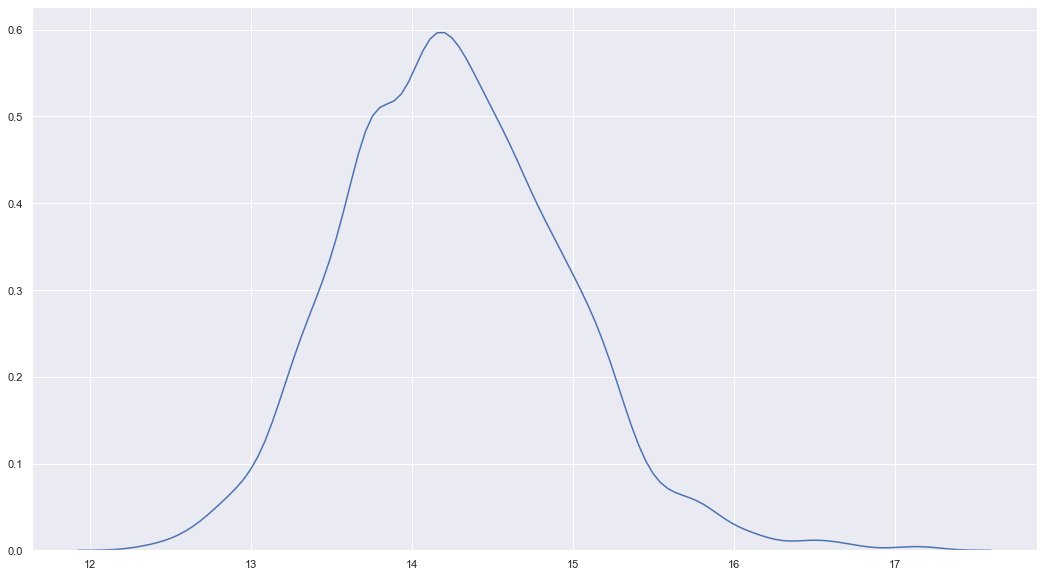

In [58]:
plt.figure(figsize=(18, 10))
sns.kdeplot(np.log1p(all_y))
plt.show()

In [59]:
all_y = np.log1p(all_y)

In [60]:
df_columns = all_df.columns.values.tolist()

In [61]:
train_X, valid_X, train_Y, valid_Y = train_test_split(all_x, all_y, test_size=0.1, random_state=42)

In [62]:
# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [63]:
print('---> cv train to choose best_num_boost_round')
dtrain = xgb.DMatrix(train_X, label=train_Y, feature_names=df_columns)

xgb_params = {
    'learning_rate': 0.005,
    'n_estimators': 4000,
    'max_depth': 3,
    'min_child_weight': 1.5,
    'eval_metric': 'rmse',
    'objective': 'reg:linear',
    'nthread': -1,
    'silent': 1,
    'booster': 'gbtree'
}

cv_result = xgb.cv(dict(xgb_params),
                   dtrain,
                   num_boost_round=4000,#迭代次数
                   early_stopping_rounds=100,#早起停止次数
                   verbose_eval=100,#每隔100次迭代输出一次
                   show_stdv=False,
                   )
best_num_boost_rounds = len(cv_result)
mean_train_logloss = cv_result.loc[best_num_boost_rounds-11 : best_num_boost_rounds-1, 'train-rmse-mean'].mean()
mean_test_logloss = cv_result.loc[best_num_boost_rounds-11 : best_num_boost_rounds-1, 'test-rmse-mean'].mean()
print('best_num_boost_rounds = {}'.format(best_num_boost_rounds))

print('mean_train_rmse = {:.7f} , mean_valid_rmse = {:.7f}\n'.format(mean_train_logloss, mean_test_logloss))

---> cv train to choose best_num_boost_round
[0]	train-rmse:13.7074	test-rmse:13.7074
[100]	train-rmse:8.31285	test-rmse:8.31301
[200]	train-rmse:5.04329	test-rmse:5.04361
[300]	train-rmse:3.06142	test-rmse:3.06207
[400]	train-rmse:1.86025	test-rmse:1.86108
[500]	train-rmse:1.13265	test-rmse:1.13382
[600]	train-rmse:0.692758	test-rmse:0.694452
[700]	train-rmse:0.428063	test-rmse:0.430632
[800]	train-rmse:0.270692	test-rmse:0.274505
[900]	train-rmse:0.179698	test-rmse:0.184926
[1000]	train-rmse:0.129984	test-rmse:0.136776
[1100]	train-rmse:0.105027	test-rmse:0.113029
[1200]	train-rmse:0.0933917	test-rmse:0.102088
[1300]	train-rmse:0.0880827	test-rmse:0.0971507
[1400]	train-rmse:0.085479	test-rmse:0.0948443
[1500]	train-rmse:0.084049	test-rmse:0.0936813
[1600]	train-rmse:0.0831757	test-rmse:0.09305
[1700]	train-rmse:0.0825487	test-rmse:0.0926373
[1800]	train-rmse:0.0820453	test-rmse:0.09231
[1900]	train-rmse:0.081586	test-rmse:0.092043
[2000]	train-rmse:0.0811873	test-rmse:0.0918327
[210

In [64]:
print('---> training on total dataset to predict test and submit')
model = xgb.train(dict(xgb_params),
                  dtrain,
                  num_boost_round=best_num_boost_rounds)

---> training on total dataset to predict test and submit


In [65]:
feature_importance = model.get_fscore()

In [66]:
feature_importance = sorted(feature_importance.items(), key=lambda d: d[1], reverse=True)

In [67]:
feature_importance

[('建筑面积', 8380),
 ('所属小区平均单价_x', 6692),
 ('纬度', 1326),
 ('经度', 942),
 ('建造年代', 930),
 ('总楼层', 783),
 ('所在楼层', 754),
 ('房屋户型_卫数', 646),
 ('装修程度', 624),
 ('房屋户型_室数', 620),
 ('房屋户型_厅数', 567),
 ('建造年代平均单价', 550),
 ('房屋朝向', 421),
 ('所属小区房源个数', 385),
 ('唯一住房', 240),
 ('配套电梯', 164),
 ('房本年限', 154),
 ('房屋类型', 153),
 ('产权年限', 98),
 ('产权性质', 91),
 ('一手房源', 70)]

In [68]:
print(df_columns)

['建筑面积', '建造年代', '房屋朝向', '房屋类型', '所在楼层', '装修程度', '产权年限', '配套电梯', '房本年限', '产权性质', '唯一住房', '一手房源', '经度', '纬度', '房屋户型_室数', '房屋户型_厅数', '房屋户型_卫数', '总楼层', '所属小区平均单价_x', '所属小区平均单价_y', '所属小区房源个数', '建造年代平均单价']


In [69]:
dvalid = xgb.DMatrix(valid_X, feature_names=df_columns)
predict_valid = model.predict(dvalid)

In [70]:
predict_price = np.expm1(predict_valid)

In [71]:
valid_true_price = np.expm1(valid_Y)

In [72]:
print('决策树模型在验证集上的均方误差 RMSE 为：', rmse(valid_Y, predict_valid))

决策树模型在验证集上的均方误差 RMSE 为： 0.08066896610419055


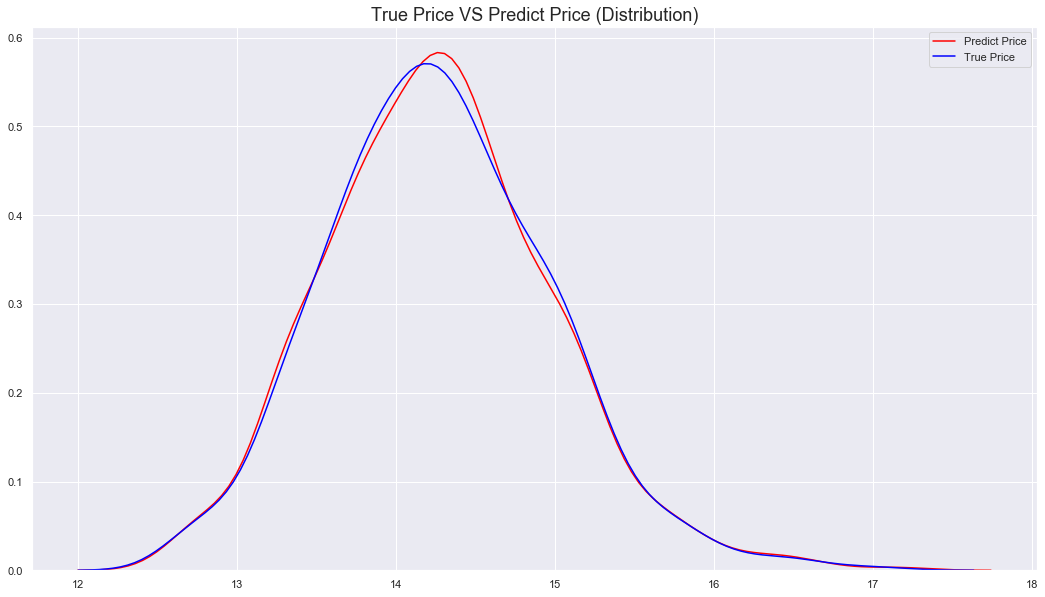

In [73]:
plt.figure(figsize=(18, 10))
sns.kdeplot(predict_valid, color='red', label='Predict Price')
sns.kdeplot(valid_Y, color='blue', label='True Price')
plt.title('True Price VS Predict Price (Distribution)', size=18)
plt.legend()
plt.show()

## 模型保存

In [74]:
model.save_model('house_price.model')

## 模型加载

In [75]:
model = xgb.Booster(model_file='house_price.model')

In [76]:
model